In [75]:
import dotenv

dotenv.load_dotenv()

True

In [76]:
classes_name = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

In [77]:
import tensorflow as tf
import numpy as np

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


In [78]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = "./data/pascal_voc_training_data.txt"
IMAGE_DIR = "./data/VOCdevkit_train/VOC2007/JPEGImages/"

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

In [79]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, "r")

        for line in input_file:
            line = line.strip()
            ss = line.split(" ")
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE)
            )
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                ] * (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][
                    : MAX_OBJECTS_PER_IMAGE * 5
                ]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image / 255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices(
            (
                self.image_names,
                np.array(self.record_list),
                np.array(self.object_num_list),
            )
        )
        # dataset = dataset.shuffle(100000)
        dataset = dataset.map(
            self._data_preprocess,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

images: (8, 448, 448, 3)
labels: (8, 20, 5)
object_nums: (8,)


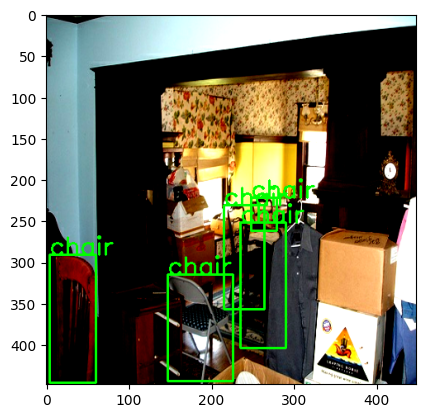

In [80]:
import cv2
import matplotlib.pyplot as plt

dataset = DatasetGenerator()

for image, labels, object_num in dataset.generate().take(1):
    print("images:", image.shape)
    print("labels:", labels.shape)
    print("object_nums:", object_num.shape)

    np_img = image[0].numpy().copy()
    np_img = np_img + 1 / 2
    np_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))

    for i in range(int(object_num[0])):
        x_center, y_center, box_w, box_h, class_num = labels[0, i]
        xmin, ymin, xmax, ymax = (
            x_center - box_w / 2,
            y_center - box_h / 2,
            x_center + box_w / 2,
            y_center + box_h / 2,
        )
        cv2.putText(
            np_img,
            classes_name[int(class_num)],
            (int(xmin), int(ymin)),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
        cv2.rectangle(
            np_img,
            (int(xmin), int(ymin)),
            (int(xmax), int(ymax)),
            (0, 255, 0),
            2,
        )
    plt.imshow(np_img)
    plt.show()
    break

In [81]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(
        filters,
        size,
        stride,
        padding="same",
        kernel_initializer=tf.keras.initializers.TruncatedNormal(),
    )(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [88]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(
    4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(
    1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)
)(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [83]:
YOLO.summary()

Model: "YOLO"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 112, 112, 192)  │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 112, 112, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 56, 56, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 56, 56, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 56, 56, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_59 (LeakyReLU)      │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 256)    │       131,32

 Total params: 271,703,550 (1.01 GB)

 Trainable params: 271,703,550 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [
            IMAGE_SIZE / CELL_SIZE * x,
            IMAGE_SIZE / CELL_SIZE * y,
            0,
            0,
        ]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])


def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.0
    size = predicts.shape[0]

    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j : j + 1, :])
            loss = loss + results

    return loss / size


def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    # boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack(
        [
            boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2,
            boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
            boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2,
            boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2,
        ]
    )

    # boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack(
        [
            boxes2[0] - boxes2[2] / 2,
            boxes2[1] - boxes2[3] / 2,
            boxes2[0] + boxes2[2] / 2,
            boxes2[1] + boxes2[3] / 2,
        ]
    )

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(
        intersection[:, :, :, 1] > 0, tf.float32
    )

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (
        boxes1[:, :, :, 3] - boxes1[:, :, :, 1]
    )
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square / (square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(
        tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]),
        tf.int32,
    )
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(
        tf.stack(
            [
                center_y,
                CELL_SIZE - center_y - 1,
                center_x,
                CELL_SIZE - center_x - 1,
            ]
        ),
        tf.int32,
    )
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL :]

    predict_boxes = tf.reshape(
        predict_boxes, [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]
    )
    # cell position to pixel position
    predict_boxes = predict_boxes * [
        IMAGE_SIZE / CELL_SIZE,
        IMAGE_SIZE / CELL_SIZE,
        IMAGE_SIZE,
        IMAGE_SIZE,
    ]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(
        response, (CELL_SIZE, CELL_SIZE, 1)
    )

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES : NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(
        tf.minimum(
            IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])
        )
    )
    p_sqrt_h = tf.sqrt(
        tf.minimum(
            IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])
        )
    )

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = (
        tf.nn.l2_loss(
            tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)
        )
        * CLASS_SCALE
    )

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (
        tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE))
        + tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE))
        + tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE
        + tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE
    ) * COORD_SCALE
    return class_loss + object_loss + noobject_loss + coord_loss


import tensorflow as tf
import numpy as np

# Load data from the saved .npz file
loaded_data = np.load("yolo_test_data.npz")
predicts_tf = tf.convert_to_tensor(loaded_data["predicts"])
labels_tf = tf.convert_to_tensor(loaded_data["labels"])
objects_num_tf = tf.convert_to_tensor(loaded_data["objects_num"])

# Calculate loss
loss = losses_calculation(predicts_tf[0], labels_tf[0, 0])
print("Loss:", loss.numpy())
loss = yolo_loss(predicts_tf, labels_tf, objects_num_tf)
print("Loss:", loss.numpy())

Loss: 44380696.0
Loss: 193628480.0


In [ ]:
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

for idx, (image, labels, objects_num) in enumerate(dataset):
    outputs = YOLO(image)
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = tf.concat([class_probs, confs, boxes], 3)

    loss = yolo_loss(predicts, labels, objects_num)
    print(f"Batch {idx}, Loss: {loss.numpy()}")
    break

Batch 0, Loss: 644355.625


In [72]:
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name="loss")
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(
    ckpt, "./ckpts/tf/YOLO", max_to_keep=3, checkpoint_name="yolo"
)


@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))
    return loss

In [73]:
from datetime import datetime

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        loss_metric = train_step(image, labels, objects_num)
        if idx % 50 == 0:
            print(
                f"Epoch {i+1:3d}, batch {idx+1:4d}, loss {loss_metric:10.4f}"
            )

    print("Epoch {}: loss {:.2f}".format(i + 1, train_loss_metric.result()))

    save_path = manager.save()
    print(
        "Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path)
    )

2024-11-06 08:13:04.766956, start training.
Epoch   1, batch    1, loss 150138.2969
Epoch   1, batch   51, loss    21.9437
Epoch   1, batch  101, loss    33.5625
Epoch   1, batch  151, loss    19.7551
Epoch   1, batch  201, loss    18.8404
Epoch   1, batch  251, loss    21.3570
Epoch   1, batch  301, loss    15.8650
Epoch   1, batch  351, loss    21.4010
Epoch   1, batch  401, loss    22.0943
Epoch   1, batch  451, loss    25.4225
Epoch   1, batch  501, loss    24.9293
Epoch   1, batch  551, loss    18.3259
Epoch   1, batch  601, loss    15.3463


W0000 00:00:1730880987.066033 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.068032 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.069297 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.070519 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.071753 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.073237 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.074806 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.076099 3800023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730880987.077829 3800023 gp

Epoch 1: loss 320.70


2024-11-06 08:16:28.828448: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 1: ./ckpts/tf/YOLO/yolo-1
Epoch   2, batch    1, loss    16.9131


KeyboardInterrupt: 

In [19]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    # choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(
        coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4)
    )

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w / 2.0
    ymin = ycenter - h / 2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [20]:
test_img_files = open("./data/pascal_voc_testing_data.txt")
test_img_dir = "./data/VOCdevkit_test/VOC2007/JPEGImages/"
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(" ")
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)


def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir + image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image / 255) * 2 - 1

    return image_name, image, h, w


test_dataset = test_dataset.map(
    load_img_data, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
test_dataset = test_dataset.batch(32)
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore("./ckpts/tf/YOLO/yolo-3")

In [21]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [22]:
output_file = open("./output/test_prediction.txt", "w")

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(
            prediction_step(test_img[i : i + 1])
        )
        xmin, ymin, xmax, ymax = (
            xmin * (img_w[i : i + 1] / IMAGE_SIZE),
            ymin * (img_h[i : i + 1] / IMAGE_SIZE),
            xmax * (img_w[i : i + 1] / IMAGE_SIZE),
            ymax * (img_h[i : i + 1] / IMAGE_SIZE),
        )

        # img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(
            img_name[i : i + 1].numpy()[0].decode("ascii")
            + " %d %d %d %d %d %f\n"
            % (xmin, ymin, xmax, ymax, class_num, conf)
        )

output_file.close()

W0000 00:00:1730858311.089473 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.090366 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.090829 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.091275 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.091696 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.092179 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.092673 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.093166 3631492 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730858311.093662 3631492 gp

In [28]:
from utils.evaluate import evaluate

# evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate(
    "./output/test_prediction.txt",
    "./output/eval_output_file.csv",
    "./data/evaluate/test_ans_encrypt.txt",
)

End Evalutation


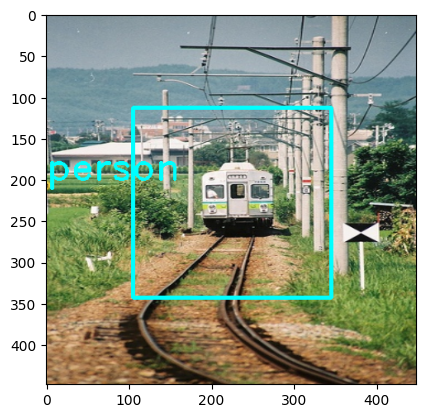

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

np_img = cv2.imread("./data/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg")
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(
    resized_img,
    (int(xmin), int(ymin)),
    (int(xmax), int(ymax)),
    (0, 255, 255),
    3,
)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()